# Ortho Dataset Multiclass Classification

**Goal** - Create similar model outputs to Automated ML and Designer with coded examples

Outline of Notebook
- Import Libraries and Initial Setup
- (Optional) Create datastore and upload dataset from UCI ML datasets directly on notebooks
- Load dataset and perform initial exploratory data analysis
- Prepare data for model
- Train model and understand performance with test dataset
- Next Steps

## Notes and References
- Link to Source Data: http://archive.ics.uci.edu/ml/datasets/vertebral+column
- Link to additional inforamtion on GitHub: https://github.com/van-william/azure-ml-demo

# Import Libraries and Initial Setup

In [1]:
#Standard Python ML Libraries
import logging
import json
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import arff
import requests, zipfile
from IPython.display import Image
from IPython.display import display
import sys
import math
import numpy as np
import seaborn as sns
import random
random.seed(42)

#Import Azure libraries
import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.core import Datastore

# Import Sklearn
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, fbeta_score

ModuleNotFoundError: No module named 'azureml'

In [ ]:
# connect to your workspace
ws = Workspace.from_config()

experiment_name = "ortho-experiment-medium"
exp = Experiment(workspace=ws, name=experiment_name)

In [ ]:
curr_path = os.getcwd()
print(curr_path)

In [2]:
# Custom Heatmap Plot
# Source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def corr_plot(df):
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 10))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 11, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Create Datastore and Upload Dataset

- We've already walked through how to extract the ortho data from UCI datasets, but the code below shows how to extract the data directly from the web
- This provides the opportunity for additional automation and functionality with a wider range of datasets
- The code block belows downloads the zip file of the files and then unzips it to the current directory.  Later the files are read in as a pandas dataframe
- We'll later push register these files to a datastore and later a dataset.
- If you want to skip ahead, you can also read in the existing ortho dataset from the dataset module

## Extract Data from UCI Site in python

In [3]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'

# Download the data
r = requests.get(f_zip)

# Write the zip file to the azure machine learning
with open('./ortho-zip.zip', 'wb') as f:
    f.write(r.content)

# Open and unzip the file
with zipfile.ZipFile('./ortho-zip.zip', 'r') as zip:
    # printing all the contents of the zip file
    print('directory: \n')
    zip.printdir()
    # extracting all the files
    zip.extractall()

# Load the .arff file
data_dict = arff.load(open('./column_3C_weka.arff'))

# Create a pandas dataframe from the .arff file
data_arff = data_dict["data"]
attributes = data_dict['attributes']
features = [item[0] for item in attributes]
ortho_3C_df = pd.DataFrame(data = data_arff, columns = features)
ortho_3C_df.head()

directory: 

File Name                                             Modified             Size
column_2C.dat                                  2011-08-09 16:13:06        11796
column_2C_weka.arff                            2011-08-09 16:02:30        25142
column_3C.dat                                  2011-08-09 16:12:10        11796
column_3C_weka.arff                            2011-08-09 16:00:40        26389


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


## Register the pandas dataframe to the datastore and dataset

In [ ]:
datastore = Datastore.get(ws, 'azure_ml_ortho_data')
dataset = Dataset.Tabular.register_pandas_dataframe(ortho_3C_df, datastore, 'Ortho-3C-dataset-from-notebook', show_progress=True)

# Read dataset from Azure machine learning datasets and initial data exploration
- We did this in a bit of a redundant way to just show the ability to write data to datastores and datastores
- We'll read in the dataset file and start to examine the data
- Note, you can read the prepped dataset from my GitHub if preferred too
https://github.com/van-william/azure-ml-demo

In [ ]:
dataset = Dataset.get_by_name(ws, name='Ortho-3C-dataset-from-notebook')
# Note, this differs from the dataset consume example code, as the workspace (ws) has already been defined

# Convert to pandas dataframe and preview
ortho_3C_df = dataset.to_pandas_dataframe()
ortho_3C_df.head()

## Initial Exploratory Data Analysis (EDA)

In [ ]:
ortho_3C_df.describe(include = 'all')

In [ ]:
ortho_3C_df.std() / ortho_3C_df.mean()

In [ ]:
corr_plot(ortho_3C_df)

In [ ]:
sns.pairplot(ortho_3C_df)

### Try PCA for visualization

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca_df = ortho_3C_df[['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
pca = PCA(n_components=2)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(pca_df)
pca_dimensions_scaled = pd.DataFrame(data = pca.fit_transform(scaled_df), columns = ['PC1', 'PC2'])
clustered_scaled_df = pd.concat([ortho_3C_df, pca_dimensions_scaled], axis=1, join="inner")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

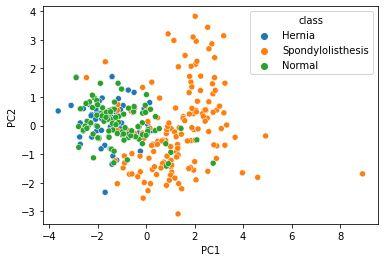

In [5]:
sns.scatterplot(data=clustered_scaled_df, x="PC1", y="PC2", hue="class")

## Create Folder for Pipeline

In [ ]:
import os
# Create a folder for the pipeline step files
experiment_folder = 'ortho_pipeline'
os.makedirs(experiment_folder, exist_ok=True)

print(experiment_folder)

## Create Dat Prep Script

In [ ]:
%%writefile $experiment_folder/prep_ortho.py
# Import libraries
import os
import argparse
import pandas as pd
from azureml.core import Run
from sklearn.preprocessing import StandardScaler

# Get parameters
parser = argparse.ArgumentParser()
parser.add_argument("--input-data", type=str, dest='raw_dataset_id', help='raw dataset')
parser.add_argument('--prepped-data', type=str, dest='prepped_data', default='prepped_data', help='Folder for results')
args = parser.parse_args()
save_folder = args.prepped_data

# Get the experiment run context
run = Run.get_context()

# load the data (passed as an input dataset)
print("Loading Data...")
ortho = run.input_datasets['raw_data'].to_pandas_dataframe()

# Normalize the numeric columns
scaler = StandardScaler()
num_cols = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
            'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']
ortho[num_cols] = scaler.fit_transform(ortho[num_cols])

# Save the prepped data
print("Saving Data...")
os.makedirs(save_folder, exist_ok=True)
save_path = os.path.join(save_folder,'data.csv')
ortho.to_csv(save_path, index=False, header=True)

# End the run
run.complete()

## Create Training Script

In [ ]:
%%writefile $experiment_folder/train_ortho.py
# Import libraries
import argparse, joblib, os
from azureml.core import Run
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

# Get the experiment run context
run = Run.get_context()

# Get script arguments
parser = argparse.ArgumentParser()

# Input dataset
parser.add_argument("--prepped-data", type=str, dest='prepped_data', help='training dataset')

# Add arguments to args collection
args = parser.parse_args()

# Load Prepped Data
dataset = args.prepped_data

# Get the experiment run context
run = Run.get_context()

# load the prepared data file in the training folder
print("Loading Data...")
file_path = os.path.join(dataset,'data.csv')
ortho_ds = pd.read_csv(file_path)

# Separate features and labels
num_cols = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle','sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']
X = ortho_ds[num_cols].values
y = ortho_ds['class'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a Gradient Boosting classification model with the specified hyperparameters
print('Training a classification model')
model = SVC(C=1,kernel='linear',probability=True).fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', float(acc))

# calculate AUC
auc = roc_auc_score(y_hat, model.predict_proba(X_test), multi_class='ovr')
print('AUC: ' + str(auc))
run.log('AUC', float(auc))

# Save the trained model in the outputs folder
print("Saving model...")
os.makedirs('outputs', exist_ok=True)
model_file = os.path.join('outputs', 'ortho_model.pkl')
joblib.dump(value=model, filename=model_file)

# Register the model
print('Registering model...')
Model.register(workspace=run.experiment.workspace,
               model_path = model_file,
               model_name = 'ortho_model',
               tags={'Training context':'Pipeline'},
               properties={'AUC': np.float(auc), 'Accuracy': np.float(acc)})

run.complete()

## Create Compute

In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "training-cluster"

try:
    # Check for existing compute target
    training_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # If it doesn't already exist, create it
    try:
        compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D1', max_nodes=1)
        training_cluster = ComputeTarget.create(ws, cluster_name, compute_config)
        training_cluster.wait_for_completion(show_output=True)
    except Exception as ex:
        print(ex)

## Build Environment

In [ ]:
from azureml.core import Workspace, Environment
from azureml.core.runconfig import RunConfiguration

#use curated environment
env = Environment.get(workspace=ws, name="AzureML-sklearn-1.0-ubuntu20.04-py38-cpu")

# Create a new runconfig object for the pipeline
pipeline_run_config = RunConfiguration()

# Use the compute you created above. 
pipeline_run_config.target = training_cluster

# Assign the environment to the run configuration
pipeline_run_config.environment = env

print ("Run configuration created.")

## Build Pipeline Configuration

In [ ]:
from azureml.data import OutputFileDatasetConfig
from azureml.pipeline.steps import PythonScriptStep

# Get the training dataset
ortho_ds = ws.datasets.get('Ortho-3C-dataset-from-notebook')

# Create an OutputFileDatasetConfig (temporary Data Reference) for data passed from step 1 to step 2
prepped_data = OutputFileDatasetConfig("prepped_data")

# Step 1, Run the data prep script
prep_step = PythonScriptStep(name = "Prepare Data",
                                source_directory = experiment_folder,
                                script_name = "prep_ortho.py",
                                arguments = ['--input-data', ortho_ds.as_named_input('raw_data'),
                                             '--prepped-data', prepped_data],
                                compute_target = training_cluster,
                                runconfig = pipeline_run_config,
                                allow_reuse = True)

# Step 2, run the training script
train_step = PythonScriptStep(name = "Train and Register Model",
                                source_directory = experiment_folder,
                                script_name = "train_ortho.py",
                                arguments = ['--prepped-data', prepped_data.as_input()],
                                compute_target = training_cluster,
                                runconfig = pipeline_run_config,
                                allow_reuse = True)

print("Pipeline steps defined")

## Run Pipeline

In [23]:
from azureml.core import Experiment
from azureml.widgets import RunDetails
from azureml.pipeline.core import Pipeline, StepSequence
from azureml.pipeline.steps import PythonScriptStep

# Construct the pipeline
step_sequence = StepSequence(steps=[prep_step, train_step])
pipeline = Pipeline(workspace=ws, steps=step_sequence)
print("Pipeline is built.")

# Create an experiment and run the pipeline
pipeline_run = exp.submit(pipeline, regenerate_outputs=True)
print("Pipeline submitted for execution.")
RunDetails(pipeline_run).show()
pipeline_run.wait_for_completion(show_output=True)

Pipeline is built.
Created step Prepare Data [984bc5e2][9a0f278a-583b-44f8-8842-fd750b77fddd], (This step will run and generate new outputs)Created step Train and Register Model [3d059ccd][b1382636-24b1-48e4-a08e-b7d1cbe79e38], (This step will run and generate new outputs)

Submitted PipelineRun 162f976f-1da1-4f09-88cd-f785471ee6c8
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/162f976f-1da1-4f09-88cd-f785471ee6c8?wsid=/subscriptions/a728c376-964f-4402-984a-92e11703958a/resourcegroups/ml-demo/workspaces/ortho-ml-demo&tid=513294a0-3e20-41b2-a970-6d30bf1546fa
Pipeline submitted for execution.


_PipelineWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', …

PipelineRunId: 162f976f-1da1-4f09-88cd-f785471ee6c8
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/162f976f-1da1-4f09-88cd-f785471ee6c8?wsid=/subscriptions/a728c376-964f-4402-984a-92e11703958a/resourcegroups/ml-demo/workspaces/ortho-ml-demo&tid=513294a0-3e20-41b2-a970-6d30bf1546fa
PipelineRun Status: Running


StepRunId: 10c7ba75-aa12-48c0-a0fe-b9e2a7c3fafb
Link to Azure Machine Learning Portal: https://ml.azure.com/runs/10c7ba75-aa12-48c0-a0fe-b9e2a7c3fafb?wsid=/subscriptions/a728c376-964f-4402-984a-92e11703958a/resourcegroups/ml-demo/workspaces/ortho-ml-demo&tid=513294a0-3e20-41b2-a970-6d30bf1546fa
StepRun( Prepare Data ) Status: Running

StepRun(Prepare Data) Execution Summary
StepRun( Prepare Data ) Status: Finished
{'runId': '10c7ba75-aa12-48c0-a0fe-b9e2a7c3fafb', 'target': 'training-cluster', 'status': 'Completed', 'startTimeUtc': '2022-03-21T04:24:56.830902Z', 'endTimeUtc': '2022-03-21T04:36:13.15372Z', 'services': {}, 'properties': {'ContentSnapshotId': '3fc91

'Finished'

In [24]:
for run in pipeline_run.get_children():
    print(run.name, ':')
    metrics = run.get_metrics()
    for metric_name in metrics:
        print('\t',metric_name, ":", metrics[metric_name])

Train and Register Model :
	 Accuracy : 0.8172043010752689
	 AUC : 0.9996584699453552
Prepare Data :


In [28]:
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

diabetes_model version: 3
	 Training context : Parameterized script
	 AUC : 0.8484377332205582
	 Accuracy : 0.774


diabetes_model version: 2
	 Training context : Script
	 AUC : 0.8483377282451863
	 Accuracy : 0.774


diabetes_model version: 1
	 Training context : Hyperdrive
	 AUC : 0.9885804604667666
	 Accuracy : 0.9457777777777778


diabetes_mitigated_20 version: 1


diabetes_mitigated_19 version: 1


diabetes_mitigated_18 version: 1


diabetes_mitigated_17 version: 1


diabetes_mitigated_16 version: 1


diabetes_mitigated_15 version: 1


diabetes_mitigated_14 version: 1


diabetes_mitigated_13 version: 1


diabetes_mitigated_12 version: 1


diabetes_mitigated_11 version: 1


diabetes_mitigated_10 version: 1


diabetes_mitigated_9 version: 1


diabetes_mitigated_8 version: 1


diabetes_mitigated_7 version: 1


diabetes_mitigated_6 version: 1


diabetes_mitigated_5 version: 1


diabetes_mitigated_4 version: 1


diabetes_mitigated_3 version: 1


diabetes_mitigated_2 version: 1


diabet

In [26]:
# Publish the pipeline from the run
published_pipeline = pipeline_run.publish_pipeline(
    name="ortho-training-pipeline", description="Trains ortho model", version="1.0")

published_pipeline

Name,Id,Status,Endpoint
ortho-training-pipeline,6ed69c84-994a-4e2f-8103-566aae49f251,Active,REST Endpoint


In [27]:
rest_endpoint = published_pipeline.endpoint
print(rest_endpoint)

https://eastus.api.azureml.ms/pipelines/v1.0/subscriptions/a728c376-964f-4402-984a-92e11703958a/resourceGroups/ml-demo/providers/Microsoft.MachineLearningServices/workspaces/ortho-ml-demo/PipelineRuns/PipelineSubmit/6ed69c84-994a-4e2f-8103-566aae49f251
